In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.7/548.7 kB 4.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
import pandas as pd
import h5py
import timm
import matplotlib.pyplot as plt
import seaborn
import time

import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from timm.scheduler import CosineLRScheduler


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
di = '/kaggle/input/g2net-detecting-continuous-gravitational-waves'

%matplotlib inline

In [4]:
train_labels = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/train_labels.csv')
submission = pd.read_csv('../input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv')

In [5]:
train_labels.head()

,id,target
0,001121a05,1
1,004f23b2d,1
2,00a6db666,1
3,00f36a6ac,1
4,010a387db,1


In [6]:
train_labels['target'].value_counts()

 1    400
 0    200
-1      3
Name: target, dtype: int64

In [7]:
#Removing the negative labels
train_labels = train_labels[train_labels.target>=0]
train_labels.target.value_counts()

1    400
0    200
Name: target, dtype: int64

In [8]:
submission.head()

,id,target
0,00054c878,0.5
1,0007285a3,0.5
2,00076c5a6,0.5
3,001349290,0.5
4,001a52e92,0.5


In [9]:
example_train = '../input/g2net-detecting-continuous-gravitational-waves/train/001121a05.hdf5'

In [10]:
f = h5py.File(example_train, 'r')

In [11]:
f.keys()

<KeysViewHDF5 ['001121a05']>

In [12]:
group1 = f['001121a05']

In [13]:
group1

<HDF5 group "/001121a05" (3 members)>

In [14]:
group1.keys()

<KeysViewHDF5 ['H1', 'L1', 'frequency_Hz']>

In [15]:
h1 = group1['H1']

In [16]:
h1.keys()

<KeysViewHDF5 ['SFTs', 'timestamps_GPS']>

In [17]:
SFT_1 = h1['SFTs']

In [18]:
SFT_1.shape

(360, 4612)

In [19]:
SFT_1[0:2]

array([[-2.0178011e-24+1.7066067e-22j, -1.4645843e-23+9.6421383e-23j,
         1.3910385e-23-4.3923662e-23j, ...,
        -1.7177181e-23+1.2837293e-22j,  1.3892107e-22-8.2977672e-23j,
         7.2729580e-23+4.4559575e-23j],
       [-1.8711387e-22+1.0073502e-22j, -1.5109396e-22+9.3674566e-24j,
         5.0192982e-23-5.2098252e-23j, ...,
        -5.9722122e-23-1.0904593e-22j,  8.0738399e-23+1.6148876e-22j,
         1.4760140e-22+1.0795126e-22j]], dtype=complex64)

In [20]:
with h5py.File(example_train, 'r') as f:
    
    group_1_list = list(f.keys())
    print("First layer groups:", group_1_list)
    
    group_1 = f[group_1_list[0]]
    group_2_list = list(group_1.keys())
    print("Second layer groups:", group_2_list)
    
    group_2 = group_1[group_2_list[0]]
    group_3_list = list(group_2.keys())
    print("Third layer groups:", group_3_list)
    
    print("key:", group_2_list[0], ", shape:", group_1[group_2_list[0]]['SFTs'].shape)
    print("key:", group_2_list[1], ", shape:", group_1[group_2_list[1]]['SFTs'].shape)
    print("key:", group_2_list[2], ", shape:", group_1[group_2_list[2]].shape)

First layer groups: ['001121a05']
Second layer groups: ['H1', 'L1', 'frequency_Hz']
Third layer groups: ['SFTs', 'timestamps_GPS']
key: H1 , shape: (360, 4612)
key: L1 , shape: (360, 4653)
key: frequency_Hz , shape: (360,)


In [21]:
count = 0
train_files = []
test_files = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        count += 1
        path = os.path.join(dirname, filename)
        
        if 'test' in dirname:
            test_files.append(path)
            
        if 'train' in dirname:
            train_files.append(path)
            
        if count%1000 == 0:
            print(count, 'data files loaded')

1000 data files loaded
2000 data files loaded
3000 data files loaded
4000 data files loaded
5000 data files loaded
6000 data files loaded
7000 data files loaded
8000 data files loaded


In [22]:
train_files[0]

'/kaggle/input/g2net-detecting-continuous-gravitational-waves/train/0517ef7fe.hdf5'

In [23]:
#defining a configuration
class CFG:
    model_name = 'tf_efficientnet_b4_ns'
    target_size = 1
    transform = True
    flip_rate = 0.5
    fre_shift_rate = 1.0
    time_mask_num = 1
    freq_mask_num = 2
    nfold = 5
    is_cross_validate = True
    batch_size = 32
    epochs = 25
    num_workers = 2
    lr = 1e-3
    weight_decay = 1e-6
    train = True
    seed = 42
    score_method = 'roc_auc_score'
    scheduler_type = 'CosineLRScheduler'
    optimizer_type = 'Adam'
    loss_type = 'BCEWithLogitsLoss'
    max_grad_norm = 1000
    lr_max = 4e-4
    epochs_warmup = 1.0

In [24]:
def get_criterion():
    if CFG.loss_type == 'CrossEntropyLoss':
        return nn.CrossEntropyLoss()
    if CFG.loss_type == 'BCEWithLogitsLoss':
        return nn.BCEWithLogitsLoss()

In [25]:
def get_optimizer(model):
    if CFG.optimizer_type == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay, amsgrad=False)
    if CFG.optimizer_type == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG.lr_max, weight_decay=CFG.weight_decay)
    return optimizer

In [26]:
def get_scheduler(optimizer, warmup, nsteps):
    if CFG.scheduler_type == 'StepLR':
        scheduler = StepLR(optimizer, step_size=2, gamma=0.1, verbose=True)
    if CFG.scheduler_type == 'CosineLRScheduler':
        scheduler = CosineLRScheduler(optimizer,
                                      warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True,
                                      t_initial=(nsteps - warmup), lr_min=1e-6) 
    return scheduler

In [27]:
def get_score(y_true, y_pred):
    if CFG.score_method == "roc_auc_score":
        score = roc_auc_score(y_true, y_pred)
    if CFG.score_method == "accuracy_score":
        score = accuracy_score(y_true, y_pred)
    return score

In [28]:
def transform(img):
    transforms_time_mask = nn.Sequential(
                torchaudio.transforms.TimeMasking(time_mask_param=10),
            )
    transforms_freq_mask = nn.Sequential(
                torchaudio.transforms.FrequencyMasking(freq_mask_param=10),
            )
    if np.random.rand() <= CFG.flip_rate: # horizontal flip
        img = np.flip(img, axis=1).copy()
    if np.random.rand() <= CFG.flip_rate: # vertical flip
        img = np.flip(img, axis=2).copy()
    if np.random.rand() <= CFG.fre_shift_rate: # vertical shift
        img = np.roll(img, np.random.randint(low=0, high=img.shape[1]), axis=1)
            
    img = torch.from_numpy(img)

    for _ in range(CFG.time_mask_num): # tima masking
        img = transforms_time_mask(img)
    for _ in range(CFG.freq_mask_num): # frequency masking
        img = transforms_freq_mask(img)
        
    return img

In [29]:
class Dataset(torch.utils.data.Dataset):
    """
    dataset = Dataset(data_type, df)

    img, y = dataset[i]
      img (np.float32): 2 x 360 x 128
      y (np.float32): label 0 or 1
    """
    def __init__(self, data_type, df):
        self.data_type = data_type
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        """
        i (int): get ith data
        """
        r = self.df.iloc[i]
        y = np.float32(r.target)
        file_id = r.id

        img = np.empty((2, 360, 128), dtype=np.float32)

        filename = '%s/%s/%s.hdf5' % (di, self.data_type, file_id)
        with h5py.File(filename, 'r') as f:
            g = f[file_id]

            for ch, s in enumerate(['H1', 'L1']):
                a = g[s]['SFTs'][:, :4096] * 1e22  # Fourier coefficient complex64

                p = a.real**2 + a.imag**2  # power
                p /= np.mean(p)  # normalize
                p = np.mean(p.reshape(360, 128, 32), axis=2)  # compress 4096 -> 128

                img[ch] = p
                
        if CFG.transform:
            img = transform(img)

        return img, y

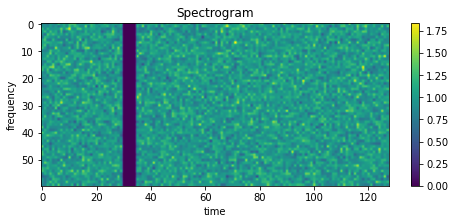

In [30]:
dataset = Dataset('train', train_labels)
img, y = dataset[10]

plt.figure(figsize=(8, 3))
plt.title('Spectrogram')
plt.xlabel('time')
plt.ylabel('frequency')
plt.imshow(img[0, 300:360]) # zooming in for dataset[10]
plt.colorbar()
plt.show()

In [31]:
len(dataset)

600

In [32]:
class Model(nn.Module):
    def __init__(self, name, *, pretrained=False):
        """
        name (str): timm model name, e.g. tf_efficientnet_b2_ns
        """
        super().__init__()

        # Use timm
        model = timm.create_model(name, pretrained=pretrained, in_chans=2)

        clsf = model.default_cfg['classifier']
        n_features = model._modules[clsf].in_features
        model._modules[clsf] = nn.Identity()

        self.fc = nn.Linear(n_features, 1)
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

In [33]:
        
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train() # switch to training mode
    nbatch = len(train_loader)
    running_loss = 0
    count = 0
    tb = time.time()
    
    pbar = tqdm(train_loader, total=len(train_loader))
    pbar.set_description(f"[{epoch+1}/{CFG.epochs}] Train")
        
    for ibatch, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        running_loss += loss.item()*labels.shape[0]
        count += labels.shape[0]
        
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        optimizer.step()
        scheduler.step(epoch * nbatch + ibatch + 1)
        optimizer.zero_grad()
            
    lr_now = optimizer.param_groups[0]['lr']
    dt = (time.time()-tb)/60
    train_dict = {'loss': running_loss/count,
                     'lr_now': lr_now,
                     'time': dt}
        
    return train_dict


def valid_fn(valid_loader, model, criterion, device, compute_score=True):
    
    tb = time.time() 
    model.eval() # switch to evaluation mode
    preds = []
    y_all = []
    running_loss = 0
    count = 0
    
    pbar = tqdm(valid_loader, total=len(valid_loader))
    pbar.set_description("Validation")
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        running_loss += loss.item()*labels.shape[0]
        count += labels.shape[0]
        # record accuracy
        y_all.append(labels.cpu().detach().numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    
    del loss, images, labels, y_preds
    
    y_ground = np.concatenate(y_all)
    y_pred = np.concatenate(preds)
    score = get_score(y_ground, y_pred) if compute_score else None 
    val_loss = running_loss/count
    
    val_dict = {'loss': val_loss,
               'score': score,
               'y': y,
               'y_pred': y_pred,
                'time': (time.time() - tb)/60
               }
    
    return val_dict

In [34]:
# Train loop
def train_loop(data):
    
    if CFG.is_cross_validate:
    
        kfold = StratifiedKFold(n_splits=CFG.nfold, random_state=42, shuffle=True)
        for ifold, (idx_train, idx_test) in enumerate(kfold.split(data['id'], data['target'])):

            print('Fold %d/%d' %(ifold, CFG.nfold))
            torch.manual_seed(CFG.seed + ifold + 1)
            # create dataset
            train_dataset = Dataset('train', data.iloc[idx_train])
            valid_dataset = Dataset('train', data.iloc[idx_test])

            # create dataloaider
            train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, 
                                      num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
            valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, 
                                      num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

            # create model and transfer to device

            model = Model(CFG.model_name, pretrained=True)
            model.to(device)

            # select optimizer, scheduler and criterion
            optimizer = get_optimizer(model)
            nbatch = len(train_loader)
            warmup = CFG.epochs_warmup*nbatch
            nsteps = CFG.epochs*nbatch
            scheduler = get_scheduler(optimizer, warmup, nsteps)
            criterion = get_criterion()

            time_val = 0.0
            tb = time.time()
            # start training
            for epoch in range(CFG.epochs):
                # train
                train_dict = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)
                # validation
                val_dict = valid_fn(valid_loader, model, criterion, device)

                time_val += val_dict['time']

                print('Epoch = %d train_loss = %.4f val_loss = %.4f val_score = %.4f lr = %.2e time = %.2f min' % (epoch+1, train_dict['loss'], val_dict['loss'], 
                                                                 val_dict['score'], train_dict['lr_now'], train_dict['time']))
            dt = (time.time() - tb)/60
            print('Training done %.2f min total, %.2f min val'% (dt, time_val))

            output_file = 'model%d.pytorch'%ifold
            torch.save(model.state_dict(), output_file)
            print(output_file, 'written')

In [35]:
# main
def main():
    if CFG.train: 
        # train
        train_loop(train_labels)

In [36]:
if __name__ == '__main__':
    main()

Fold 0/5


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth
Validation: 100%|██████████| 4/4 [00:27<00:00,  6.84s/it]


Epoch = 1 train_loss = 0.6821 val_loss = 0.6510 val_score = 0.4634 lr = 4.00e-04 time = 1.89 min


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.20s/it]


Epoch = 2 train_loss = 0.6357 val_loss = 0.6226 val_score = 0.6253 lr = 3.98e-04 time = 2.01 min


Validation: 100%|██████████| 4/4 [00:30<00:00,  7.53s/it]


Epoch = 3 train_loss = 0.6140 val_loss = 0.5577 val_score = 0.7116 lr = 3.93e-04 time = 1.93 min


Validation: 100%|██████████| 4/4 [00:29<00:00,  7.44s/it]


Epoch = 4 train_loss = 0.5767 val_loss = 0.5344 val_score = 0.7069 lr = 3.85e-04 time = 1.92 min


Validation: 100%|██████████| 4/4 [00:29<00:00,  7.42s/it]


Epoch = 5 train_loss = 0.5506 val_loss = 0.5273 val_score = 0.7188 lr = 3.73e-04 time = 2.02 min


Validation: 100%|██████████| 4/4 [00:29<00:00,  7.26s/it]


Epoch = 6 train_loss = 0.5451 val_loss = 0.4844 val_score = 0.7947 lr = 3.59e-04 time = 1.91 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.04s/it]


Epoch = 7 train_loss = 0.5369 val_loss = 0.4876 val_score = 0.7244 lr = 3.42e-04 time = 1.86 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.50s/it]


Epoch = 8 train_loss = 0.5206 val_loss = 0.4586 val_score = 0.7994 lr = 3.22e-04 time = 1.87 min


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.24s/it]


Epoch = 9 train_loss = 0.4900 val_loss = 0.4748 val_score = 0.7762 lr = 3.00e-04 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.43s/it]


Epoch = 10 train_loss = 0.5074 val_loss = 0.4897 val_score = 0.7594 lr = 2.77e-04 time = 1.81 min


Validation: 100%|██████████| 4/4 [00:33<00:00,  8.39s/it]


Epoch = 11 train_loss = 0.4992 val_loss = 0.4981 val_score = 0.7381 lr = 2.52e-04 time = 2.00 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.28s/it]


Epoch = 12 train_loss = 0.5001 val_loss = 0.4525 val_score = 0.8059 lr = 2.27e-04 time = 1.93 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.11s/it]


Epoch = 13 train_loss = 0.4971 val_loss = 0.4617 val_score = 0.7784 lr = 2.00e-04 time = 1.79 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.05s/it]


Epoch = 14 train_loss = 0.4836 val_loss = 0.4872 val_score = 0.7384 lr = 1.74e-04 time = 1.83 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.12s/it]


Epoch = 15 train_loss = 0.4893 val_loss = 0.5031 val_score = 0.7256 lr = 1.49e-04 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.98s/it]


Epoch = 16 train_loss = 0.5021 val_loss = 0.4632 val_score = 0.8128 lr = 1.24e-04 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.98s/it]


Epoch = 17 train_loss = 0.4777 val_loss = 0.4756 val_score = 0.7569 lr = 1.01e-04 time = 1.81 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.03s/it]


Epoch = 18 train_loss = 0.4586 val_loss = 0.4897 val_score = 0.7581 lr = 7.91e-05 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:32<00:00,  8.14s/it]


Epoch = 19 train_loss = 0.4659 val_loss = 0.4774 val_score = 0.7638 lr = 5.94e-05 time = 1.84 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.94s/it]


Epoch = 20 train_loss = 0.4568 val_loss = 0.4536 val_score = 0.8234 lr = 4.22e-05 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.09s/it]


Epoch = 21 train_loss = 0.4612 val_loss = 0.4770 val_score = 0.7741 lr = 2.77e-05 time = 1.85 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  7.00s/it]


Epoch = 22 train_loss = 0.4531 val_loss = 0.4519 val_score = 0.8184 lr = 1.62e-05 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.72s/it]


Epoch = 23 train_loss = 0.4580 val_loss = 0.4628 val_score = 0.7800 lr = 7.80e-06 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.43s/it]


Epoch = 24 train_loss = 0.4680 val_loss = 0.4766 val_score = 0.7712 lr = 2.71e-06 time = 1.73 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.75s/it]


Epoch = 25 train_loss = 0.4526 val_loss = 0.4592 val_score = 0.8012 lr = 1.00e-06 time = 1.72 min
Training done 58.22 min total, 11.80 min val
model0.pytorch written
Fold 1/5


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.02s/it]


Epoch = 1 train_loss = 0.6775 val_loss = 0.6340 val_score = 0.5956 lr = 4.00e-04 time = 1.83 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.79s/it]


Epoch = 2 train_loss = 0.6130 val_loss = 0.6850 val_score = 0.6022 lr = 3.98e-04 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.66s/it]


Epoch = 3 train_loss = 0.5844 val_loss = 0.5807 val_score = 0.6566 lr = 3.93e-04 time = 1.92 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.51s/it]


Epoch = 4 train_loss = 0.5698 val_loss = 0.5622 val_score = 0.6869 lr = 3.85e-04 time = 1.72 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.66s/it]


Epoch = 5 train_loss = 0.5293 val_loss = 0.5801 val_score = 0.6725 lr = 3.73e-04 time = 1.77 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.65s/it]


Epoch = 6 train_loss = 0.5297 val_loss = 0.5495 val_score = 0.7062 lr = 3.59e-04 time = 1.73 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.75s/it]


Epoch = 7 train_loss = 0.5047 val_loss = 0.5182 val_score = 0.7303 lr = 3.42e-04 time = 1.75 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.67s/it]


Epoch = 8 train_loss = 0.5119 val_loss = 0.5152 val_score = 0.7497 lr = 3.22e-04 time = 1.72 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.64s/it]


Epoch = 9 train_loss = 0.5224 val_loss = 0.5133 val_score = 0.7219 lr = 3.00e-04 time = 1.71 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.54s/it]


Epoch = 10 train_loss = 0.5120 val_loss = 0.5138 val_score = 0.7013 lr = 2.77e-04 time = 1.72 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.52s/it]


Epoch = 11 train_loss = 0.4957 val_loss = 0.5135 val_score = 0.7275 lr = 2.52e-04 time = 1.71 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.34s/it]


Epoch = 12 train_loss = 0.4805 val_loss = 0.4993 val_score = 0.7547 lr = 2.27e-04 time = 1.73 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.65s/it]


Epoch = 13 train_loss = 0.4690 val_loss = 0.4665 val_score = 0.8075 lr = 2.00e-04 time = 1.71 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.32s/it]


Epoch = 14 train_loss = 0.4881 val_loss = 0.4901 val_score = 0.7859 lr = 1.74e-04 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.59s/it]


Epoch = 15 train_loss = 0.4701 val_loss = 0.5201 val_score = 0.7006 lr = 1.49e-04 time = 1.70 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.30s/it]


Epoch = 16 train_loss = 0.4763 val_loss = 0.5171 val_score = 0.7241 lr = 1.24e-04 time = 1.68 min


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.22s/it]


Epoch = 17 train_loss = 0.4594 val_loss = 0.4835 val_score = 0.7644 lr = 1.01e-04 time = 1.69 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.57s/it]


Epoch = 18 train_loss = 0.4463 val_loss = 0.5422 val_score = 0.7103 lr = 7.91e-05 time = 1.68 min


Validation: 100%|██████████| 4/4 [00:30<00:00,  7.61s/it]


Epoch = 19 train_loss = 0.4521 val_loss = 0.5426 val_score = 0.7137 lr = 5.94e-05 time = 1.77 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.80s/it]


Epoch = 20 train_loss = 0.4678 val_loss = 0.5091 val_score = 0.7337 lr = 4.22e-05 time = 1.75 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.68s/it]


Epoch = 21 train_loss = 0.4631 val_loss = 0.5481 val_score = 0.6787 lr = 2.77e-05 time = 1.75 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.60s/it]


Epoch = 22 train_loss = 0.4373 val_loss = 0.5179 val_score = 0.7350 lr = 1.62e-05 time = 1.69 min


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.18s/it]


Epoch = 23 train_loss = 0.4363 val_loss = 0.5243 val_score = 0.7334 lr = 7.80e-06 time = 1.72 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.66s/it]


Epoch = 24 train_loss = 0.4418 val_loss = 0.4803 val_score = 0.7741 lr = 2.71e-06 time = 1.75 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.54s/it]


Epoch = 25 train_loss = 0.4448 val_loss = 0.5115 val_score = 0.7353 lr = 1.00e-06 time = 1.73 min
Training done 54.54 min total, 11.04 min val
model1.pytorch written
Fold 2/5


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.40s/it]


Epoch = 1 train_loss = 0.6582 val_loss = 0.6733 val_score = 0.4747 lr = 4.00e-04 time = 1.71 min


Validation: 100%|██████████| 4/4 [00:30<00:00,  7.62s/it]


Epoch = 2 train_loss = 0.6312 val_loss = 0.6079 val_score = 0.6475 lr = 3.98e-04 time = 1.69 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.53s/it]


Epoch = 3 train_loss = 0.5923 val_loss = 0.5795 val_score = 0.6825 lr = 3.93e-04 time = 1.86 min


Validation: 100%|██████████| 4/4 [00:36<00:00,  9.08s/it]


Epoch = 4 train_loss = 0.5727 val_loss = 0.5630 val_score = 0.6825 lr = 3.85e-04 time = 1.92 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.59s/it]


Epoch = 5 train_loss = 0.5466 val_loss = 0.5478 val_score = 0.7141 lr = 3.73e-04 time = 2.05 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.62s/it]


Epoch = 6 train_loss = 0.5259 val_loss = 0.5357 val_score = 0.7087 lr = 3.59e-04 time = 1.71 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.48s/it]


Epoch = 7 train_loss = 0.5223 val_loss = 0.5196 val_score = 0.7078 lr = 3.42e-04 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.57s/it]


Epoch = 8 train_loss = 0.5031 val_loss = 0.5503 val_score = 0.7037 lr = 3.22e-04 time = 1.67 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.45s/it]


Epoch = 9 train_loss = 0.5175 val_loss = 0.5366 val_score = 0.6891 lr = 3.00e-04 time = 1.67 min


Validation: 100%|██████████| 4/4 [00:33<00:00,  8.41s/it]


Epoch = 10 train_loss = 0.5014 val_loss = 0.4795 val_score = 0.8150 lr = 2.77e-04 time = 1.81 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.12s/it]


Epoch = 11 train_loss = 0.4927 val_loss = 0.5000 val_score = 0.7591 lr = 2.52e-04 time = 2.06 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.50s/it]


Epoch = 12 train_loss = 0.4961 val_loss = 0.5215 val_score = 0.7319 lr = 2.27e-04 time = 1.72 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.37s/it]


Epoch = 13 train_loss = 0.4843 val_loss = 0.5264 val_score = 0.6897 lr = 2.00e-04 time = 1.74 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.46s/it]


Epoch = 14 train_loss = 0.4851 val_loss = 0.5224 val_score = 0.7447 lr = 1.74e-04 time = 1.67 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.42s/it]


Epoch = 15 train_loss = 0.4828 val_loss = 0.5452 val_score = 0.6787 lr = 1.49e-04 time = 1.65 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.35s/it]


Epoch = 16 train_loss = 0.4617 val_loss = 0.5201 val_score = 0.7031 lr = 1.24e-04 time = 1.68 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.42s/it]


Epoch = 17 train_loss = 0.4877 val_loss = 0.4831 val_score = 0.7859 lr = 1.01e-04 time = 1.64 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.41s/it]


Epoch = 18 train_loss = 0.4675 val_loss = 0.5162 val_score = 0.6822 lr = 7.91e-05 time = 1.65 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.46s/it]


Epoch = 19 train_loss = 0.4822 val_loss = 0.4737 val_score = 0.7784 lr = 5.94e-05 time = 1.69 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.53s/it]


Epoch = 20 train_loss = 0.4684 val_loss = 0.4831 val_score = 0.7847 lr = 4.22e-05 time = 1.68 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.70s/it]


Epoch = 21 train_loss = 0.4613 val_loss = 0.4554 val_score = 0.8184 lr = 2.77e-05 time = 1.72 min


Validation: 100%|██████████| 4/4 [00:30<00:00,  7.74s/it]


Epoch = 22 train_loss = 0.4699 val_loss = 0.4626 val_score = 0.8134 lr = 1.62e-05 time = 1.72 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.99s/it]


Epoch = 23 train_loss = 0.4531 val_loss = 0.4833 val_score = 0.7644 lr = 7.80e-06 time = 2.49 min


Validation: 100%|██████████| 4/4 [00:25<00:00,  6.30s/it]


Epoch = 24 train_loss = 0.4555 val_loss = 0.5003 val_score = 0.7328 lr = 2.71e-06 time = 1.75 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.64s/it]


Epoch = 25 train_loss = 0.4536 val_loss = 0.5025 val_score = 0.6953 lr = 1.00e-06 time = 1.74 min
Training done 55.84 min total, 11.35 min val
model2.pytorch written
Fold 3/5


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.61s/it]


Epoch = 1 train_loss = 0.6795 val_loss = 0.6466 val_score = 0.5316 lr = 4.00e-04 time = 1.73 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.74s/it]


Epoch = 2 train_loss = 0.6156 val_loss = 0.7419 val_score = 0.6269 lr = 3.98e-04 time = 1.77 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.80s/it]


Epoch = 3 train_loss = 0.5945 val_loss = 0.5710 val_score = 0.6959 lr = 3.93e-04 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.72s/it]


Epoch = 4 train_loss = 0.5562 val_loss = 0.5437 val_score = 0.7263 lr = 3.85e-04 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.78s/it]


Epoch = 5 train_loss = 0.5548 val_loss = 0.5142 val_score = 0.7703 lr = 3.73e-04 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.85s/it]


Epoch = 6 train_loss = 0.5305 val_loss = 0.5232 val_score = 0.6928 lr = 3.59e-04 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.82s/it]


Epoch = 7 train_loss = 0.5052 val_loss = 0.5440 val_score = 0.6806 lr = 3.42e-04 time = 1.76 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.84s/it]


Epoch = 8 train_loss = 0.5083 val_loss = 0.5035 val_score = 0.7209 lr = 3.22e-04 time = 1.77 min


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.77s/it]


Epoch = 9 train_loss = 0.5135 val_loss = 0.5105 val_score = 0.7125 lr = 3.00e-04 time = 1.83 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.81s/it]


Epoch = 10 train_loss = 0.4909 val_loss = 0.5058 val_score = 0.7541 lr = 2.77e-04 time = 2.15 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.81s/it]


Epoch = 11 train_loss = 0.5005 val_loss = 0.4877 val_score = 0.7622 lr = 2.52e-04 time = 1.77 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.79s/it]


Epoch = 12 train_loss = 0.4948 val_loss = 0.5014 val_score = 0.7169 lr = 2.27e-04 time = 1.83 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.02s/it]


Epoch = 13 train_loss = 0.4905 val_loss = 0.5284 val_score = 0.6897 lr = 2.00e-04 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.87s/it]


Epoch = 14 train_loss = 0.4779 val_loss = 0.5038 val_score = 0.7197 lr = 1.74e-04 time = 1.95 min


Validation: 100%|██████████| 4/4 [00:31<00:00,  7.76s/it]


Epoch = 15 train_loss = 0.4782 val_loss = 0.5088 val_score = 0.7269 lr = 1.49e-04 time = 1.88 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.80s/it]


Epoch = 16 train_loss = 0.4802 val_loss = 0.4792 val_score = 0.7719 lr = 1.24e-04 time = 2.05 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.74s/it]


Epoch = 17 train_loss = 0.4980 val_loss = 0.4845 val_score = 0.7803 lr = 1.01e-04 time = 1.75 min


Validation: 100%|██████████| 4/4 [00:24<00:00,  6.18s/it]


Epoch = 18 train_loss = 0.4794 val_loss = 0.4581 val_score = 0.8569 lr = 7.91e-05 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.81s/it]


Epoch = 19 train_loss = 0.4788 val_loss = 0.4827 val_score = 0.8006 lr = 5.94e-05 time = 1.77 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.83s/it]


Epoch = 20 train_loss = 0.4687 val_loss = 0.4843 val_score = 0.7772 lr = 4.22e-05 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.72s/it]


Epoch = 21 train_loss = 0.4550 val_loss = 0.4747 val_score = 0.7991 lr = 2.77e-05 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.90s/it]


Epoch = 22 train_loss = 0.4601 val_loss = 0.4780 val_score = 0.7719 lr = 1.62e-05 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.11s/it]


Epoch = 23 train_loss = 0.4571 val_loss = 0.4809 val_score = 0.7828 lr = 7.80e-06 time = 1.81 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.89s/it]


Epoch = 24 train_loss = 0.4530 val_loss = 0.4634 val_score = 0.7812 lr = 2.71e-06 time = 1.87 min


Validation: 100%|██████████| 4/4 [00:29<00:00,  7.26s/it]


Epoch = 25 train_loss = 0.4636 val_loss = 0.4808 val_score = 0.7788 lr = 1.00e-06 time = 1.80 min
Training done 57.15 min total, 11.49 min val
model3.pytorch written
Fold 4/5


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.86s/it]


Epoch = 1 train_loss = 0.6621 val_loss = 0.7104 val_score = 0.4763 lr = 4.00e-04 time = 1.83 min


Validation: 100%|██████████| 4/4 [00:39<00:00,  9.98s/it]


Epoch = 2 train_loss = 0.6259 val_loss = 0.6204 val_score = 0.6184 lr = 3.98e-04 time = 1.90 min


Validation: 100%|██████████| 4/4 [00:33<00:00,  8.26s/it]


Epoch = 3 train_loss = 0.5830 val_loss = 0.5523 val_score = 0.7147 lr = 3.93e-04 time = 2.22 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.88s/it]


Epoch = 4 train_loss = 0.5626 val_loss = 0.5733 val_score = 0.6716 lr = 3.85e-04 time = 2.16 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.83s/it]


Epoch = 5 train_loss = 0.5351 val_loss = 0.5677 val_score = 0.7009 lr = 3.73e-04 time = 1.79 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.93s/it]


Epoch = 6 train_loss = 0.5132 val_loss = 0.6154 val_score = 0.7169 lr = 3.59e-04 time = 1.79 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.00s/it]


Epoch = 7 train_loss = 0.5194 val_loss = 0.5097 val_score = 0.6925 lr = 3.42e-04 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.93s/it]


Epoch = 8 train_loss = 0.5029 val_loss = 0.5057 val_score = 0.7316 lr = 3.22e-04 time = 1.81 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.77s/it]


Epoch = 9 train_loss = 0.5043 val_loss = 0.5205 val_score = 0.7234 lr = 3.00e-04 time = 1.79 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.75s/it]


Epoch = 10 train_loss = 0.5085 val_loss = 0.5319 val_score = 0.7244 lr = 2.77e-04 time = 1.76 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.85s/it]


Epoch = 11 train_loss = 0.4925 val_loss = 0.5256 val_score = 0.7262 lr = 2.52e-04 time = 1.79 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.89s/it]


Epoch = 12 train_loss = 0.4868 val_loss = 0.5053 val_score = 0.7406 lr = 2.27e-04 time = 1.83 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.71s/it]


Epoch = 13 train_loss = 0.4826 val_loss = 0.5144 val_score = 0.7112 lr = 2.00e-04 time = 1.76 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.82s/it]


Epoch = 14 train_loss = 0.4694 val_loss = 0.4898 val_score = 0.7453 lr = 1.74e-04 time = 1.78 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.80s/it]


Epoch = 15 train_loss = 0.4568 val_loss = 0.4913 val_score = 0.7578 lr = 1.49e-04 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.91s/it]


Epoch = 16 train_loss = 0.4565 val_loss = 0.4818 val_score = 0.7806 lr = 1.24e-04 time = 1.85 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.75s/it]


Epoch = 17 train_loss = 0.4707 val_loss = 0.4942 val_score = 0.7859 lr = 1.01e-04 time = 1.81 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.80s/it]


Epoch = 18 train_loss = 0.4729 val_loss = 0.4933 val_score = 0.7559 lr = 7.91e-05 time = 1.80 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.84s/it]


Epoch = 19 train_loss = 0.4697 val_loss = 0.4959 val_score = 0.7406 lr = 5.94e-05 time = 1.77 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.25s/it]


Epoch = 20 train_loss = 0.4463 val_loss = 0.4920 val_score = 0.7569 lr = 4.22e-05 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.11s/it]


Epoch = 21 train_loss = 0.4501 val_loss = 0.4832 val_score = 0.7797 lr = 2.77e-05 time = 1.91 min


Validation: 100%|██████████| 4/4 [00:28<00:00,  7.01s/it]


Epoch = 22 train_loss = 0.4676 val_loss = 0.5021 val_score = 0.7253 lr = 1.62e-05 time = 2.04 min


Validation: 100%|██████████| 4/4 [00:26<00:00,  6.70s/it]


Epoch = 23 train_loss = 0.4493 val_loss = 0.5110 val_score = 0.7578 lr = 7.80e-06 time = 1.82 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.87s/it]


Epoch = 24 train_loss = 0.4368 val_loss = 0.5089 val_score = 0.7391 lr = 2.71e-06 time = 1.83 min


Validation: 100%|██████████| 4/4 [00:27<00:00,  6.98s/it]


Epoch = 25 train_loss = 0.4510 val_loss = 0.4746 val_score = 0.8069 lr = 1.00e-06 time = 2.05 min
Training done 58.30 min total, 11.77 min val
model4.pytorch written


In [37]:
#train the model on whole data and save it
